In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from material_models import Fung, GOH
from NODE_fns import forward_pass, NN
import pickle

In [2]:
#Load the NN
with open('savednet/P1C1_Fung.npy', 'rb') as f:
    Fung_wb = pickle.load(f)
with open('savednet/P1C1_GOH.npy', 'rb') as f:
    GOH_wb = pickle.load(f)

In [3]:
def matrix_from_stretch(lm1, lm2, lm3):
    zeros = np.zeros(lm1.shape)
    F = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))
    C = np.einsum('...ij,...jk->...ik', F, F.transpose(0,2,1))
    return F, C

In [4]:
lm = np.linspace(0.8, 1.5, 50)
lm1, lm2 = np.meshgrid(lm, lm)
lm3 = 1/(lm1*lm2)
F, C = matrix_from_stretch(lm1.flatten(), lm2.flatten(), lm3.flatten())
E = 0.5*(C-np.eye(3))

I1 = np.trace(C, axis1 = 1, axis2 = 2)
I2 = 0.5*(I1**2 - np.trace(C**2, axis1 = 1, axis2 = 2))
theta = Fung_wb[-1]
v0 = np.array([ np.cos(theta), np.sin(theta), 0])
w0 = np.array([-np.sin(theta), np.cos(theta), 0])
V0 = np.outer(v0, v0)
W0 = np.outer(w0, w0)
I4v = np.einsum('pij,ij->p', C, V0)
I4w = np.einsum('pij,ij->p', C, W0)

I1hat = I1-3
I2hat = I2-3
I4vhat = I4v-1
I4what = I4w-1
#Integrate to get Psi
Psi_NN_Fung = np.zeros_like(I1)
Psi_NN_GOH = np.zeros_like(I1)
for i in range(Psi_NN_Fung.shape[0]):
    npoint = 20
    dI1 = 1/npoint*I1hat[i]
    dI2 = 1/npoint*I2hat[i]
    dI4v = 1/npoint*I4vhat[i]
    dI4w = 1/npoint*I4what[i]
    dummyI1 = 0.0
    dummyI2 = 0.0
    dummyI4v = 0.0
    dummyI4w = 0.0
    for j in range(npoint):
        J1 = dummyI1+dummyI2
        J2 = dummyI1+dummyI4v
        J3 = dummyI1+dummyI4w
        J4 = dummyI2+dummyI4v
        J5 = dummyI2+dummyI4w
        J6 = dummyI4v+dummyI4w
        #dPsi/dI1 = dPhi1/dI1 + dKsi1/dJ1 + dKsi2/dJ2 + dKsi3/dJ3 where J1 = I1+I2, J2 = I1+I4v, J3 = I1+I4w
        dPsidI1 = NN(np.array([dummyI1]), GOH_wb[0]) + NN(np.array([J1]), GOH_wb[4]) + NN(np.array([J2]), GOH_wb[5]) + \
                                                           NN(np.array([J3]), GOH_wb[6])
        dPsidI2 = NN(np.array([dummyI2]), GOH_wb[1]) + NN(np.array([J1]), GOH_wb[4]) + NN(np.array([J4]), GOH_wb[7]) + \
                                                            NN(np.array([J5]), GOH_wb[8])
        dPsidI4v = NN(np.array([dummyI4v]), GOH_wb[2]) + NN(np.array([J2]), GOH_wb[5]) + NN(np.array([J4]), GOH_wb[7]) + \
                                                              NN(np.array([J6]), GOH_wb[9])
        dPsidI4w = NN(np.array([dummyI4w]), GOH_wb[3]) + NN(np.array([J3]), GOH_wb[6]) + NN(np.array([J5]), GOH_wb[8]) + \
                                                              NN(np.array([J6]), GOH_wb[9])
        Psi_NN_GOH[i]+= dPsidI1*dI1 + dPsidI2*dI2 + dPsidI4v*dI4v + dPsidI4w*dI4w
        
        
        dPsidI1 = NN(np.array([dummyI1]), Fung_wb[0]) + NN(np.array([J1]), Fung_wb[4]) + NN(np.array([J2]), Fung_wb[5]) + \
                                                           NN(np.array([J3]), Fung_wb[6])
        dPsidI2 = NN(np.array([dummyI2]), Fung_wb[1]) + NN(np.array([J1]), Fung_wb[4]) + NN(np.array([J4]), Fung_wb[7]) + \
                                                            NN(np.array([J5]), Fung_wb[8])
        dPsidI4v = NN(np.array([dummyI4v]), Fung_wb[2]) + NN(np.array([J2]), Fung_wb[5]) + NN(np.array([J4]), Fung_wb[7]) + \
                                                              NN(np.array([J6]), Fung_wb[9])
        dPsidI4w = NN(np.array([dummyI4w]), Fung_wb[3]) + NN(np.array([J3]), Fung_wb[6]) + NN(np.array([J5]), Fung_wb[8]) + \
                                                              NN(np.array([J6]), Fung_wb[9])
        Psi_NN_Fung[i]+= dPsidI1*dI1 + dPsidI2*dI2 + dPsidI4v*dI4v + dPsidI4w*dI4w
        
        dummyI1+= dI1
        dummyI2+= dI2
        dummyI4v+= dI4v
        dummyI4w+= dI4w

F = F.reshape([50,50,3,3])
C = C.reshape([50,50,3,3])
E = E.reshape([50,50,3,3])
Psi_NN_Fung = Psi_NN_Fung.reshape([50,50])
Psi_NN_GOH = Psi_NN_GOH.reshape([50,50])
I1 = I1.reshape([50,50])
I2 = I2.reshape([50,50])
I4v = I4v.reshape([50,50])
I4w = I4w.reshape([50,50])

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
#Training Data
Fung_params = [0.0024147281291801714,-1.74859889140465,-21.453946421295953,49.84357587843394]
GOH_params = [1.02356332e-02, 5.13664702e-01, 5.91491834e+01, 2.74447648e-01, 1.57079633e+00]

Fung_MM = Fung(Fung_params)
Psi_Fung = Fung_MM.Psi(np.array([lm1.flatten(), lm2.flatten()]).T).reshape([50,50])
GOH_MM = GOH(GOH_params)
Psi_GOH = GOH_MM.Psi(np.array([lm1.flatten(), lm2.flatten()]).T).reshape([50,50])

<ipython-input-7-cbd5f4c77beb>:10: UserWarning: Log scale: values of z <= 0 have been masked
  cntr = ax1.contour(E[:,:,0,0], E[:,:,1,1], Psi_GOH*1000, locator=ticker.LogLocator(), colors=colors.reshape(-1,4), levels=levels)
<ipython-input-7-cbd5f4c77beb>:20: UserWarning: Log scale: values of z <= 0 have been masked
  cntr = ax3.contour(E[:,:,0,0], E[:,:,1,1], Psi_Fung*1000, locator=ticker.LogLocator(), colors=colors.reshape(-1,4), levels=levels)


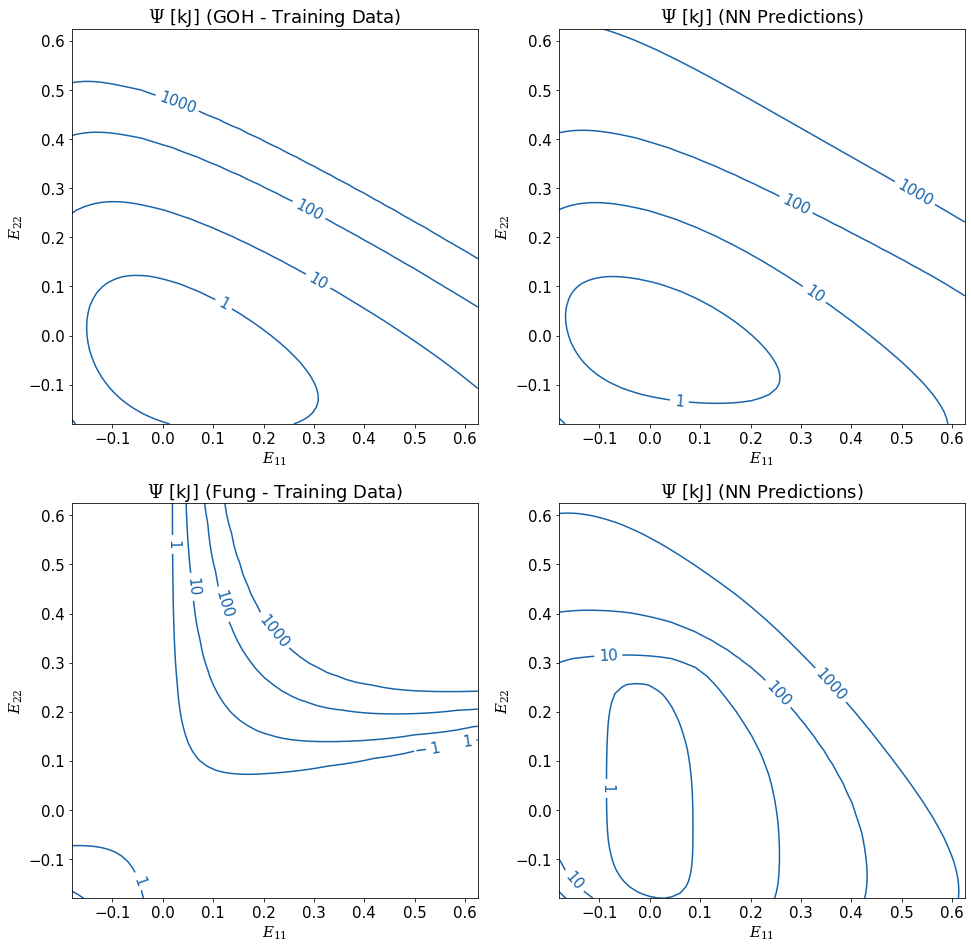

In [7]:
fig = plt.figure(figsize=(16,16))
plt.rcParams.update({'font.size': 15})
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
plt.rcParams.update({'font.sans-serif':'Arial'})
colors = np.zeros((E.shape[0],E.shape[1],4))
colors[:,:] = plt.cm.Blues(0.8)
fmt = matplotlib.ticker.FormatStrFormatter('%d')
ax1 = fig.add_subplot(221)
ax1.set(xlabel='$E_{11}$', ylabel='$E_{22}$', title = '$\Psi$ [kJ] (GOH - Training Data)')
levels = [1, 10, 100, 1000]
cntr = ax1.contour(E[:,:,0,0], E[:,:,1,1], Psi_GOH*1000, locator=ticker.LogLocator(), colors=colors.reshape(-1,4), levels=levels)
ax1.clabel(cntr, cntr.levels, fmt=fmt)

ax2 = fig.add_subplot(222)
ax2.set(xlabel='$E_{11}$', ylabel='$E_{22}$', title = '$\Psi$ [kJ] (NN Predictions)')
cntr = ax2.contour(E[:,:,0,0], E[:,:,1,1], Psi_NN_GOH*1000, locator=ticker.LogLocator(), colors=colors.reshape(-1,4), levels=levels)
ax2.clabel(cntr, cntr.levels, fmt=fmt)

ax3 = fig.add_subplot(223)
ax3.set(xlabel='$E_{11}$', ylabel='$E_{22}$', title = '$\Psi$ [kJ] (Fung - Training Data)')
cntr = ax3.contour(E[:,:,0,0], E[:,:,1,1], Psi_Fung*1000, locator=ticker.LogLocator(), colors=colors.reshape(-1,4), levels=levels)
ax3.clabel(cntr, cntr.levels, fmt=fmt)

ax4 = fig.add_subplot(224)
ax4.set(xlabel='$E_{11}$', ylabel='$E_{22}$', title = '$\Psi$ [kJ] (NN Predictions)')
cntr = ax4.contour(E[:,:,0,0], E[:,:,1,1], Psi_NN_Fung*1000, locator=ticker.LogLocator(), colors=colors.reshape(-1,4), levels=levels)
ax4.clabel(cntr, cntr.levels, fmt=fmt)
fig.savefig('Figures/rfig_convexity.jpg', dpi=400, bbox_inches='tight')
pass